In [1]:
from __future__ import annotations

In [2]:
from config.dl_model_config import DLModelConfig
from ipsqt.prediction.dl.dl_predictor import DLPredictor

from ipsqt.strategies.predicted.binary_position_strategy import BinaryPositionStrategy
from ipsqt.prediction.dl.models.mlp import MLP
from run import initialize


REBAL_FREQ = "D"
STRATEGY = BinaryPositionStrategy
MODEL = MLP

SAVE = True

In [3]:
preprocessor, runner = initialize()

predictor = DLPredictor(
    model_cls=MODEL,
    model_config=DLModelConfig(),
    n_features=len(runner.available_features),
    verbose=False,
)

strategy = STRATEGY(
    predictor=predictor,
)

strategy_name = STRATEGY.__class__.__name__
model_name = MODEL.__class__.__name__

Backtest on 2013-03-24 00:00:00 to 2024-05-05 00:00:00
Num Train Iterations: 581
Num OOS Daily Points: 581


In [4]:
result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)

Computing Weights: 100%|██████████| 581/581 [02:38<00:00,  3.66it/s]


In [5]:
result

StrategyStatistics:
* final_nav = 19425092665144374028111415586497378562306870865695553949095079286296561184064084908779423913837799677620670412543703671523793276284667026476969565813780170127734960669665727304736939454938075941171253588715822171091751571980025856.000000
* geom_avg_total_r = 332281237754646822912.000000
* geom_avg_xs_r = 332281104218000654336.000000
* std_xs_r = 12.509017
* min_xs_r = -0.090551
* max_xs_r = 5.513926
* skew = 1.332248
* kurtosis = 0.532768
* max_dd = -0.090551
* sharpe = 26563326644141346816.000000
* alpha_buy_hold = 332281092799891898368.000000
* tracking_error_buy_hold = 12.500078
* ir_buy_hold = 26582321501164953600.000000
* factor_loadings = {'_MKT': -0.354937448055205}
* alpha_benchmark = 332281108479377932288.000000
* alpha_benchmark_pvalue = 0.000000
* tracking_error_benchmark = 12.498112
* ir_benchmark = 26586503497793056768.000000
* ttest_pval = 0.000000
* levene_pval = 0.000000
* timing_ability_coef = 5.715889
* timing_ability_pval = 0.518646

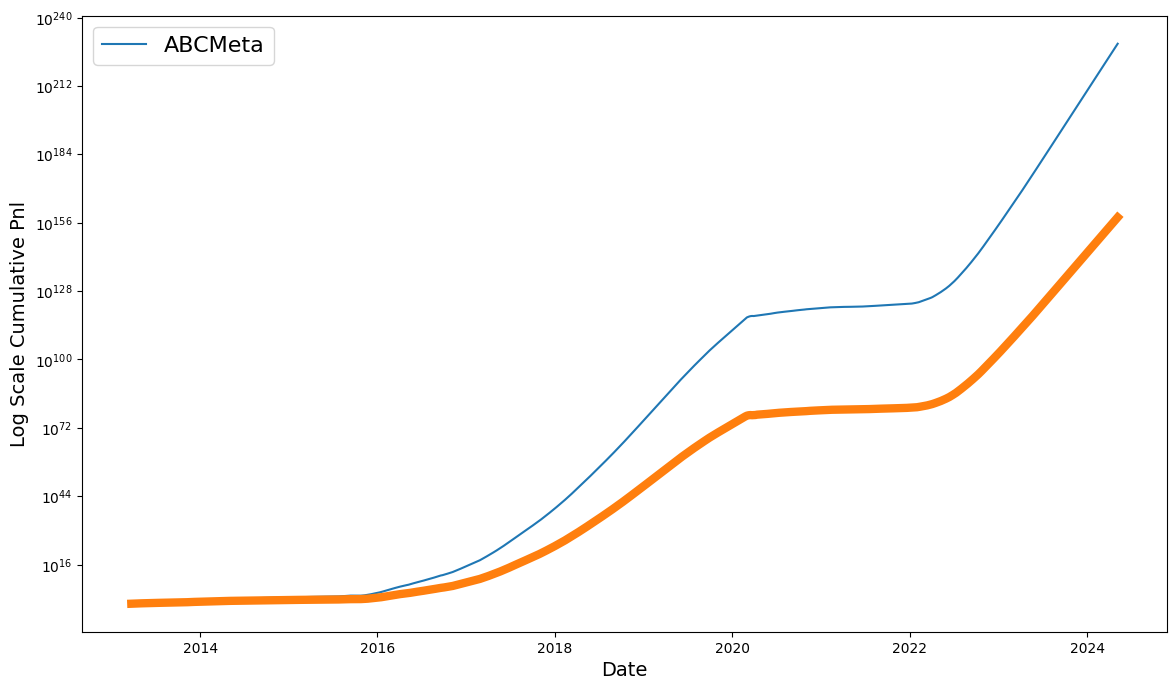

In [6]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

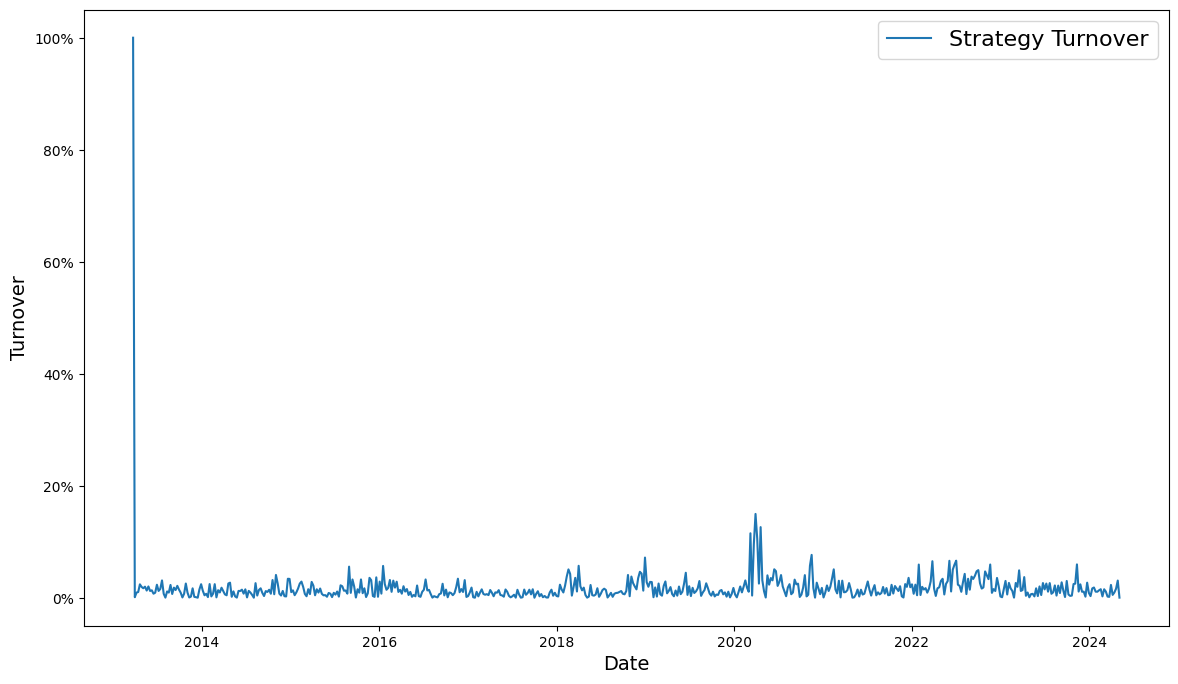

In [7]:
runner.plot_turnover()

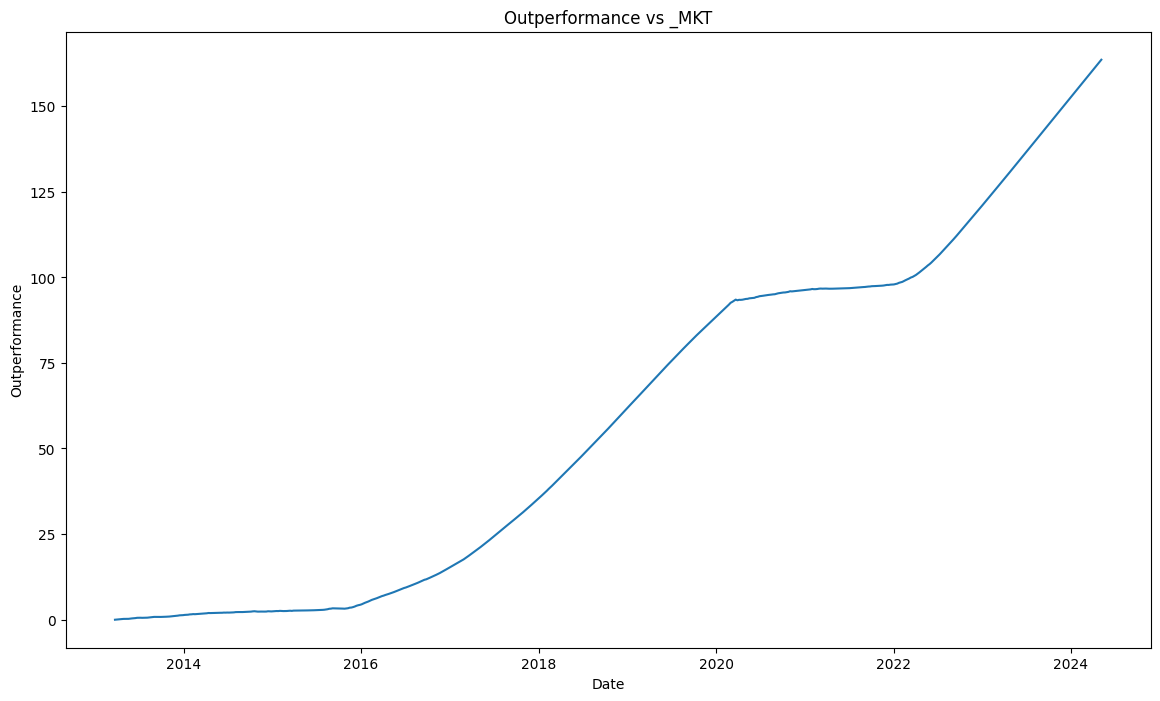

In [8]:
runner.plot_outperformance(mkt_only=True)

In [9]:
if SAVE:
    runner.save(f"{strategy_name}_" + model_name + f"_rebal{REBAL_FREQ}")

OSError: Cannot save file into a non-existent directory: '/Users/buchkovv/data/run'